# 단어의 의미 파악하기

딥러닝이 사용되기 이전에 어떤 방식으로 단어의 의미를 파악했는지 알아보자.

## 시소러스(Thesaurus)

> 정의: 단어를 의미에 따라 분류·배열한 일종의 유의어 사전

시소러스는 단어 사이의 상하 관계나 포함 관계를 고려하여 정의할 수도 있다. (이 경우엔 그래프로 표현)

단점: 시대 변화에 대응이 어렵다. 많은 인력이 필요하다. 단어의 미묘한 차이를 표현할 수 없다.

WordNet: 1985년부터 프린스턴 대학교에서 구축하기 시작한 가장 유명한 시소러스

## 통계 기반 기법

- **말뭉치(corpus)**: 수집된 텍스트 데이터. 추가 정보가 포함되는 경우가 있다(품사, 긍정 부정 여부 등).

말뭉치를 전처리하여 쉽게 다룰 수 있도록 코드를 작성해보겠다.

In [2]:
text = 'you say goodbye and I say hello.'
text = text.lower()
text = text.replace('.', ' .')
text

'you say goodbye and i say hello .'

In [3]:
words = text.split()
words

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']

단어를 효율적으로 조작하기 위해 id를 부여한다.

In [4]:
word_to_id = {}
id_to_word = {}

for word in words:
    new_id = len(word_to_id)
    word_to_id[word] = new_id
    id_to_word[new_id] = word

In [5]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [6]:
word_to_id

{'you': 0, 'say': 5, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}

말뭉치 전처리 함수를 정의한다.

In [7]:
import numpy as np

def preprocess(t):
    text = t.lower()
    text = text.replace('.', ' .')
    words = text.split()
    word_to_id = {}
    id_to_word = {}

    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])
    
    return  corpus, word_to_id, id_to_word

### 단어의 분산 표현

우리는 색을 3차원 벡터(RGB)로 표현한다. 데이터로 표현하기도 쉽고 색 끼리의 관련성을 판단하기도 용이하다. 

이처럼 단어도 벡터 공간 상에 표현할 수 있다. 이를 단어의 **분산표현(distributional representation)** 이라고 한다.

### 분포 가설

> 단어의 의미는 주변 단어에 의해 형성된다. 단어 그 자체에는 의미가 없다. 단어가 사용된 맥락(context)이 의미를 형성한다.

이는 분포 가설(distributional hypothesis)의 핵심이다. 

- 맥락(context)

    특정 단어를 중심에 둔 그 주변 단어를 의미한다.
    
    - 맥락의 크기 = window size
    
        ex) window size가 2이면 좌측 두 단어, 우측 두 단어가 맥락에 포함된다.
        
### 동시발생 행렬

> 어떤 단어의 맥락이 되는 다른 단어의 출현 빈도를 행렬로 표현한 것

In [8]:
corpus, word_to_id, id_to_word = preprocess(text)
corpus, word_to_id, id_to_word

(array([0, 1, 2, 3, 4, 1, 5, 6]),
 {'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6},
 {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'})

In [9]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    
    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i
            
            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
                
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
    
    return co_matrix

In [10]:
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

In [11]:
import pandas as pd

def draw_color_at_nan(x, color):
    if x == 1:
        color = f'background-color:{color}'
        return color
    else:
        return ''

index = [id_to_word[i] for i in range(vocab_size)]

df = pd.DataFrame(C, index=index, columns=index)
df.style.applymap(draw_color_at_nan, color='#a0c0ff')

,you,say,goodbye,and,i,hello,.
you,0,1,0,0,0,0,0
say,1,0,1,0,1,1,0
goodbye,0,1,0,1,0,0,0
and,0,0,1,0,1,0,0
i,0,1,0,1,0,0,0
hello,0,1,0,0,0,0,1
.,0,0,0,0,0,1,0


### 벡터 간 유사도

단어 벡터 사이의 유사도를 나타낼 때 **코사인 유사도(cosine similarity)** 를 자주 이용한다.

$$\text{similarity}(\textbf{x}, \textbf{y}) = cos(\theta) = \frac{\textbf{x} \cdot \textbf{y}}{\lVert \textbf{x} \rVert \lVert \textbf{y} \rVert} = \frac{x_1y_1+ \cdots +x_ny_n}{\sqrt{x_1^2+ \cdots + x_n^2}\sqrt{y_1^2+ \cdots + y_n^2}}$$

$\theta$는 두 벡터 $\textbf{x}, \textbf{y}$ 가 이루는 각도이다.

In [12]:
def cos_similarity(x, y, eps=1e-8):
    nx = x / (np.sqrt(np.sum(x**2)) + eps)
    ny = x / (np.sqrt(np.sum(y**2)) + eps)
    return np.dot(nx, ny)

"you"와 "i"의 유사도를 측정한다.

In [13]:
c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]
print(cos_similarity(c0, c1))                

0.7071067691154799


유사 단어의 랭킹을 표시할 수도 있다.

In [22]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    # 1. 검색어를 꺼낸다.
    if query not in word_to_id:
        print(f'{query}를 찾을 수 없습니다.')
        return
    
    print(f'\n[query] {query}')
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    # 2. 코사인 유사도 계산
    #    모든 word에 대해 유사도를 계산하고 정렬한다.
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
    
    # 3. 코사인 유사도를 기준으로 내림차순으로 출력
    for i in (-1 * similarity).argsort()[:top]: # 내림차순 argsort를 수행하는 간단한 trick
        if id_to_word[i] == query:
            continue
        print(f'{id_to_word[i]}: {similarity[i]}')

In [23]:
most_similar('you', word_to_id, id_to_word, C, top=5)


[query] you
say: 1.9999999700000004
goodbye: 1.4142135382309597
and: 1.4142135382309597
i: 1.4142135382309597
hello: 1.4142135382309597


## 통계 기반 기법 개선하기

### 상호정보량

단어 간의 동시발생 만으로 관계를 유추하는 것은 위험하다. ex) the, car, drive

### 점별 상호정보량(Pointwise mutual Information) PMI

$$\text{PMI}(x, y)=log_2\frac{P(x, y)}{P(x)P(y)}$$

- $P(x)$: 단어 $x$가 말뭉치에 등장할 확률
- $C(x)$: 단어 $x$의 등장 횟수
- $C(x, y)$: 단어 $x$와 $y$가 동시 발생하는 횟수

$$\text{PMI}(x, y)=log_2\frac{P(x, y)}{P(x)P(y)}=log_2\frac{\frac{C(x, y)}{N}}{\frac{C(x)}{N}\frac{C(y)}{N}}=log_2\frac{C(x, y)\cdot N}{C(x)C(y)}$$

$\text{PMI}$의 문제점은 두 단어의 동시발생 횟수가 0이면 $log_{2}0=-\infty$가 된다. 이 때문에 양의 상호정보량(Positive PMI)를 사용한다.

$$\text{PPMI}=\text{max}(0, \text{PMI}(x, y))$$

In [32]:
def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0) # 단어 x의 출현 횟수
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j] * S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total // 100 + 1) == 0:
                    print(f'{100 * cnt / total:.1f} 완료')

    return M

In [36]:
np.set_printoptions(precision=3)
W = ppmi(C)
print(C)
print(W)

[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


PPMI에도 여전히 문제가 있다.

- 말뭉치의 어휘가 증가함에 따라 각 던어 벡터의 차원 수도 증가한다.
- 원소가 대부분 0로 이루어져있는 희소행렬일 가능성이 높다. -> 각 원소의 중요도가 낮다.
- 노이즈에 약하고 견고하지 못하다.

다음과 같은 문제를 해결하기 위해 차원감소가 사용된다.

### 차원감소

SVD(Singular Value Decomposition, 특잇값분해)를 이용하여 차원을 감소시킬 수 있다. 

SVD는 임의의 행렬을 세 행렬의 곱으로 분해한다.

$$\text{X}=\text{USV}^\text{T}$$

SVD가 기억나지 않는다면 선형대수학 자료를 참고하자.

In [37]:
U, S, V = np.linalg.svd(W)
C[0], W[0], U[0]

(array([0, 1, 0, 0, 0, 0, 0], dtype=int32),
 array([0.   , 1.807, 0.   , 0.   , 0.   , 0.   , 0.   ], dtype=float32),
 array([ 3.409e-01, -1.110e-16, -1.205e-01, -4.163e-16, -9.323e-01,
        -1.110e-16, -2.426e-17], dtype=float32))

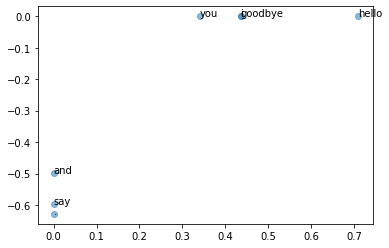

In [38]:
import matplotlib.pyplot as plt

for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))

plt.scatter(U[:, 0], U[:, 1], alpha=0.5)
plt.show()

### PTB 데이터셋

더 큰 말뭉치를 사용하여 확인해보자.

In [41]:
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')

print(f'말뭉치 크기: {len(corpus)}')
print(f'corpus[:30]: {corpus[:30]}')
print(f'len(id_to_word): {len(id_to_word)}\n')
print(f'id_to_word[0]: {id_to_word[0]}')
print(f'id_to_word[1]: {id_to_word[1]}')
print(f'id_to_word[2]: {id_to_word[2]}\n')
print(f'word_to_id["car"]: {word_to_id["car"]}')
print(f'word_to_id["happy"]: {word_to_id["happy"]}')
print(f'word_to_id["lexus"]: {word_to_id["lexus"]}')

말뭉치 크기: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
len(id_to_word): 10000

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id["car"]: 3856
word_to_id["happy"]: 4428
word_to_id["lexus"]: 7426


In [42]:
window_size = 2
wordvec_size = 100
vocab_size = len(word_to_id)
print('동시발생 수 계산...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('PPMI 계산...')
W = ppmi(C, verbose=True)

print('SVD 계산...')
try:
    # truncated SVD(특이값이 큰 것들만 계산해서 빠르다!)
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5, random_state=None)
except ImportError:
    U, S, V = np.linalg.svd(W)

word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

동시발생 수 계산...
PPMI 계산...
1.0 완료
2.0 완료
3.0 완료
4.0 완료
5.0 완료
6.0 완료
7.0 완료
8.0 완료
9.0 완료
10.0 완료
11.0 완료
12.0 완료
13.0 완료
14.0 완료
15.0 완료
16.0 완료
17.0 완료
18.0 완료
19.0 완료
20.0 완료
21.0 완료
22.0 완료
23.0 완료
24.0 완료
25.0 완료
26.0 완료
27.0 완료
28.0 완료
29.0 완료
30.0 완료
31.0 완료
32.0 완료
33.0 완료
34.0 완료
35.0 완료
36.0 완료
37.0 완료
38.0 완료
39.0 완료
40.0 완료
41.0 완료
42.0 완료
43.0 완료
44.0 완료
45.0 완료
46.0 완료
47.0 완료
48.0 완료
49.0 완료
50.0 완료
51.0 완료
52.0 완료
53.0 완료
54.0 완료
55.0 완료
56.0 완료
57.0 완료
58.0 완료
59.0 완료
60.0 완료
61.0 완료
62.0 완료
63.0 완료
64.0 완료
65.0 완료
66.0 완료
67.0 완료
68.0 완료
69.0 완료
70.0 완료
71.0 완료
72.0 완료
73.0 완료
74.0 완료
75.0 완료
76.0 완료
77.0 완료
78.0 완료
79.0 완료
80.0 완료
81.0 완료
82.0 완료
83.0 완료
84.0 완료
85.0 완료
86.0 완료
87.0 완료
88.0 완료
89.0 완료
90.0 완료
91.0 완료
92.0 완료
93.0 완료
94.0 완료
95.0 완료
96.0 완료
97.0 완료
98.0 완료
99.0 완료
SVD 계산...

[query] you
who: 2.6198220252990723
into: 2.6063780784606934
mr.: 2.519623279571533
his: 2.4457719326019287
an: 2.42289400100708

[query] year
who: 4.465244293212891
into: 4.44233036